# Imports

In [35]:
import gymnasium as gym
import numpy as np
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from gymnasium.wrappers import FlattenObservation

env = gym.make('gym_environment:gym_environment/SimpleBattery')
env = FlattenObservation(env)

# setup plots
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# DQN Model

In [4]:
"""
Transition: named tuple representing a single transition in the environment
    maps the (state, action) pairs to their (next_state,reward) result

ReplayMemory: a cyclic buffer that holds the transitions oberved recetly.
    Also has a .sample() method for selecting a random batch of transition for training

"""

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """ Save a transition """
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    


""" Custom DQN module using Q-learning """
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128,128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one elements to determine next action or a batch
    # during optimization, Returns tensor
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

# DQN Training

Complete


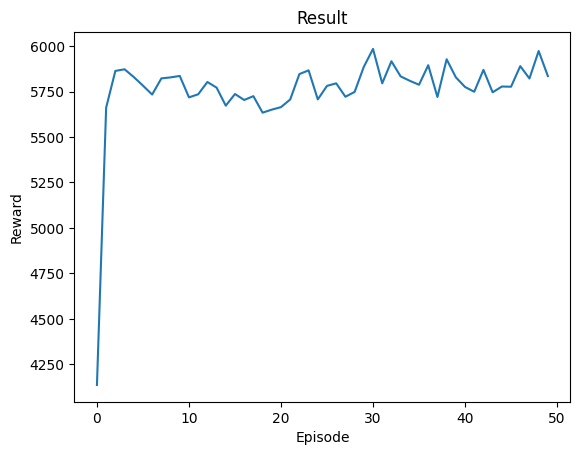

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [7]:
""" 
Training the DQN model

Hyperparameters 

select_action: will select an action according to an e-greedy policy
plot_duration: helper function for plotting the duration of episodes, 
    along with the average over the last 100 episodes
"""

# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of action from gym action space
n_actions = env.action_space.n
# Get number of state observations
state, info = env.reset()
n_observations = env.observation_space.shape[0]


policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

# TODO: random needs a seed for reproducability ?
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1 * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
    

episode_rewards = []

def plot_durations(show_result=False):
    plt.figure(1)
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(rewards_t.numpy())

    # Take 100 ep. Average and plot them
    if len(rewards_t) >= 100:
        means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.0001) # pause a bit to update plots
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True) 
        else:
            display.display(plt.gcf())

""" Training Loop """
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch. 
    # Converts batch-array of Transitions to Transitions of batch-arrays
    batch = Transition(*zip(*transitions))

    # Cumpute mask of non-final stats and concatenate the batch elements
    # (a final state would've been the one after which the simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
    
    non_final_next_states = torch.cat([s for s in batch.next_state
                                        if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()


if torch.cuda.is_available():
    num_episodes = 1200
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()

    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    total_r = 0

    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, info = env.step(action.item())
        total_r += reward
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()


        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_rewards.append(total_r)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()


# Q-Learning Agent

In [39]:
env = gym.make('gym_environment:gym_environment/GridWorld', render_mode=None, max_episode_steps=300)
env = FlattenObservation(env)

# Q-table zero init
q_table = np.zeros((n_observations, n_actions))
print(q_table)

n_episodes = 200

# init exploration probablity
exploration_proba = 1

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


# Q-Learning Training

# Model Prediction

In [33]:
env = gym.make('gym_environment:gym_environment/SimpleBattery')
env = FlattenObservation(env)

episodes = 1

episode_actions = []
episode_take_price = []
episode_feed_price = []

# Predictions
for ep in range(episodes):
    state,info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    terminated = False
    total_reward = 0

    while not terminated:
        action = select_action(state)
        observation, reward, terminated, truncated, info = env.step(action.item())

        total_reward+=reward
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            # Store action and dates
            episode_actions.append(observation[0]-3000)
            episode_take_price.append(observation[1])
            episode_feed_price.append(observation[2])




        # Move to the next state
        state = next_state
    print("Reward:{}".format(total_reward))

Reward:5838.067100000134


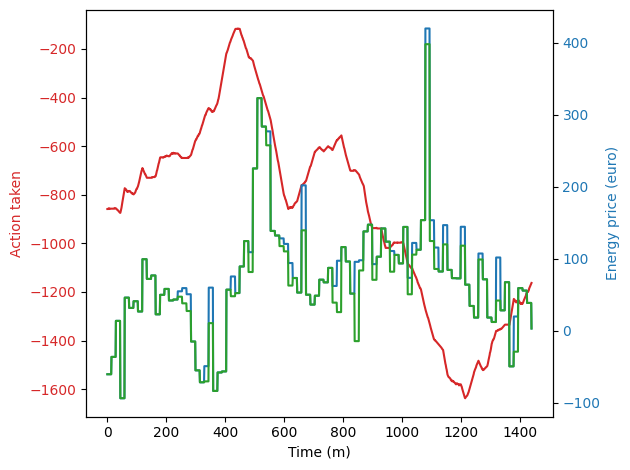

In [34]:
fig, ax1 = plt.subplots()

daily_actions = np.array(episode_actions).reshape(-1, 1440)
daily_feed_price = np.array(episode_feed_price).reshape(-1, 1440)
daily_take_price = np.array(episode_take_price).reshape(-1, 1440)

minute_average_actions = np.mean(daily_actions, axis = 0)
minute_average_feed_price = np.mean(daily_feed_price, axis = 0)
minute_average_take_price = np.mean(daily_take_price, axis = 0)


color = 'tab:red'
ax1.set_xlabel('Time (m)')
ax1.set_ylabel('Action taken', color=color)
ax1.plot(minute_average_actions, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Energy price (euro)', color=color)
ax2.plot(minute_average_feed_price, color=color)
ax2.plot(minute_average_take_price, color='tab:green')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()